<a href="https://colab.research.google.com/github/kibrus/ClassProjects/blob/main/main_bidirection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
from math import sqrt, pi
from queue import PriorityQueue
from itertools import count
from copy import copy

a_star_weight = 1
counter = count()

def best_first_search(problem, f, h):
    # Initialize start and goal nodes
    start_node = problem.root
    goal_state = (problem.goal_loc, start_node.state[1])  # Same velocity as start node
    goal_node = problem.Node(goal_state, None, None, 0, problem)

    # Initialize forward and backward frontiers
    forward_frontier = PriorityQueue(0)
    backward_frontier = PriorityQueue(0)

    forward_frontier.put((f(start_node, h), -next(counter), start_node))
    backward_frontier.put((f(goal_node, h), -next(counter), goal_node))

    # Initialize forward and backward reached sets
    forward_reached = {start_node.state: start_node}
    backward_reached = {goal_node.state: goal_node}

    while not forward_frontier.empty() and not backward_frontier.empty():
        # Check for intersection between the two frontiers
        intersection = set(forward_reached.keys()) & set(backward_reached.keys())
        if intersection:
            # Return the path through the intersection point with lowest total cost
            return get_best_path(intersection, forward_reached, backward_reached)

        # Expand forward
        if not forward_frontier.empty():
            current = forward_frontier.get(False)[2]
            for child in expand(problem, current, h):
                s = child.state
                if s not in forward_reached or child.path_cost < forward_reached[s].path_cost:
                    forward_reached[s] = child
                    forward_frontier.put((f(child, h), -next(counter), child))

        # Expand backward
        if not backward_frontier.empty():
            current = backward_frontier.get(False)[2]
            for child in expand(problem, current, h):
                s = child.state
                if s not in backward_reached or child.path_cost < backward_reached[s].path_cost:
                    backward_reached[s] = child
                    backward_frontier.put((f(child, h), -next(counter), child))

    return None

def get_best_path(intersection, forward_reached, backward_reached):
    best_cost = float('inf')
    best_meeting_state = None

    for state in intersection:
        total_cost = forward_reached[state].path_cost + backward_reached[state].path_cost
        if total_cost < best_cost:
            best_cost = total_cost
            best_meeting_state = state

    # Reconstruct the complete path
    forward_path = forward_reached[best_meeting_state]
    backward_path = backward_reached[best_meeting_state]

    # Create a new node that combines the paths
    combined_node = forward_path

    # Add the backward path's cost
    combined_node.path_cost = best_cost

    return combined_node

def expand(problem, node, h):
    s = node.state
    nodes = []
    for action in problem.actions(s):
        s_new = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action)
        new_node = problem.Node(s_new, node, action, cost, problem)
        if problem.heuristic_consistent_flag:
            problem.heuristic_consistent_flag = check_h_consistency(problem, new_node, h)
        nodes.append(new_node)

        # Keep track of the number of expanded states
        problem.num_expanded_states += 1
        problem.num_generated_nodes += len(nodes)

    return nodes

def time_to_goal(node):
    problem = node.problem
    goal_loc = problem.goal_loc
    agent_loc = node.state[problem.state_dict['agent']]
    v, theta_a = node.state[problem.state_dict['velocity']]
    a = problem.a_max
    s = problem.hex_manhattan_distance(goal_loc, agent_loc) * sqrt(3) * problem.hex_size

    return problem.get_travel_time(v, a, s)

def check_h_consistency(problem, node, h):
    if node.parent is None:
        return True

    heuristic_is_consistent = h(node.parent) <= problem.action_cost(node.parent.state, node.action) + h(node)
    if not heuristic_is_consistent:
        hn = h(node)
        hp = h(node.parent)
        ac = problem.action_cost(node.parent.state, node.action)
        print("h is inconsistent")
        print(f'ac:        {ac}')
        print(f'h(parent): {hp}')
        print(f'h(node):   {hn}')
        print(f'{hp} <= {ac} + {hn}  is false')
        print(node.state)
        print(node.parent.state)
    return heuristic_is_consistent

def f(node, h=time_to_goal):
    return g(node) + a_star_weight * h(node)

def g(node):
    return node.path_cost

class PathfindingProblem:
    class Node:
        def __init__(self, state, parent, action, path_cost, problem):
            self.state = state
            self.parent = parent
            self.action = action
            self.path_cost = path_cost

            self.problem = problem

            # if the new node has a different angle than previous
            # the agent turned, apply the turning penalty and backtrack to update velocities and path costs along the path
            if self.is_turn() and not self.is_zigzag():
                r = 1
                current_node = self.parent
                while not current_node.is_turn() and current_node.is_zigzag():
                    current_node = current_node.parent
                    r += 1

                # calculate the max velocity for the turn
                v_max = sqrt(2*r * problem.ay_max)
                if state[1][0] > v_max:
                    # update the velocity in the current node to v_max
                    self.state = (
                        self.state[0],
                        (v_max, self.state[problem.state_dict['velocity']][1])
                    )
                self.update_velocity(problem)

        def update_velocity(self, problem):
            current_node = self
            while current_node.parent:
                new_v = problem.calculate_velocity(current_node.state[problem.state_dict['velocity']][0], problem.d_max, sqrt(3) * problem.hex_size)
                if new_v < current_node.parent.state[problem.state_dict['velocity']][0]:
                    parent_copy = copy(current_node.parent)
                    parent_copy.state = (
                        parent_copy.state[0],
                        (new_v, parent_copy.state[problem.state_dict['velocity']][1])
                    )
                    if parent_copy.parent:
                        parent_path_cost = parent_copy.parent.path_cost
                    else:
                        parent_path_cost = 0

                    parent_copy.path_cost = parent_path_cost + problem.get_travel_time(parent_copy.state[problem.state_dict['velocity']][0], problem.d_max, sqrt(3) * problem.hex_size)
                    current_node.parent = parent_copy
                    if problem.heuristic_consistent_flag:
                        problem.heuristic_consistent_flag = check_h_consistency(problem, parent_copy, time_to_goal)
                    current_node = current_node.parent
                else:
                    break

        def is_turn(self):
            return self.parent is not None and self.state[self.problem.state_dict['velocity']][1] != self.parent.state[self.problem.state_dict['velocity']][1]
        def is_zigzag(self):
            return self.parent is not None and self.parent.parent is not None and self.state[self.problem.state_dict['velocity']][1] == self.parent.parent.state[self.problem.state_dict['velocity']][1]


        def __str__(self):
            return str(self.state)
    def __init__(self, initial_state, hex_map, obstacle_map, goal_loc, hex_radius, hex_size, acceleration_max, deceleration_max, lat_acceleration_max):
        self.root = self.Node(initial_state, None, None, 0, self)

        self.hex_map = hex_map
        self.obstacle_map = obstacle_map
        self.goal_loc = goal_loc
        self.hex_radius = hex_radius
        self.hex_size = hex_size
        self.a_max = acceleration_max
        self.d_max = deceleration_max
        self.ay_max = lat_acceleration_max

        # for benchmarking
        self.heuristic_consistent_flag = True
        self.num_expanded_states = 0
        self.num_generated_nodes = 0

        # Defines the indices for the components of the state
        self.state_dict = {
            'agent': 0,
            'velocity': 1
        }

        # Defines the directions to the immediate neighborhood and their angle relative to horizontal
        self.neighborhood_angles = {
            (1,0): 0,
            (0,1): pi/3,
            (-1,1): 2*pi/3,
            (-1,0): pi,
            (0,-1): 4*pi/3,
            (1,-1): 5*pi/3
        }
    def hex_manhattan_distance(self, hex1, hex2):
        q1, r1 = hex1
        q2, r2 = hex2

        dq = abs(q1-q2)
        dr = abs(r1-r2)
        ds = abs(-q1-q2-r1-r2)

        return (dq+dr+ds)/2

    # get the path cost of applying action to state
    def action_cost(self, state, action):
        u = state[self.state_dict['velocity']][0]
        a = self.a_max
        s = sqrt(3) * self.hex_size
        return self.get_travel_time(u, a, s)

    # calculate the travel time given initial velocity u, acceleration a, and distance s
    def get_travel_time(self, u, a, s):
        return (-u + sqrt(u*u + 4 * a * s))/a

    # check if the agent location in the state is the same as the goal location in the problem
    def is_goal(self, state):
        return state[self.state_dict['agent']] == self.goal_loc

    # Add two location tuples element-wise
    def add_locations(self, loc1, loc2):
        return tuple([sum(x) for x in zip(loc1,loc2)])

    # return a list of viable actions from state
    # an action is a direction tuple, eg (1, 0) is the hex to the right of the agent's location
    def actions(self, state):

        # Get the current direction of the agent in state
        # Cast to an int so it can be used to index neighborhood_angles.keys()
        # Coincidently, the values of the 6 directions correspond to their indices when casted this way
        current_angle = int(state[self.state_dict['velocity']][1])

        # Find the index values of the immediate turns in the clockwise (cw) and counter clockwise (ccw) directions
        ccw_turn_idx = current_angle + 1
        cw_turn_idx  = current_angle - 1

        # If these values are out of bounds, cycle to the front or back of the keys list
        if ccw_turn_idx > 5: ccw_turn_idx = 0
        if cw_turn_idx  < 0: cw_turn_idx  = 5

        # Find the 3 actions corresponding to the straight, cw, ccw movements
        permutations = list(self.neighborhood_angles.keys())
        turns = [ccw_turn_idx, current_angle, cw_turn_idx]
        actions = [permutations[t] for t in turns]



        # Remove obstacles and out of bounds locations from the action list
        actions = [a for a in actions
                   if self.add_locations(a, state[self.state_dict['agent']]) not in self.obstacle_map
                   and self.hex_manhattan_distance(self.add_locations(a, state[self.state_dict['agent']]), (0,0)) <= self.hex_radius
                  ]

        return actions

    # returns the result of applying action to state
    # this is done by adding action to agent location in state
    # agent_loc: (3,4)
    # action: (1,0)
    # result_loc (4,4)

    # also calculate the new velocity and angle after moving to the new location
    def result(self, state, action):

        # add the action tuple to the agent_loc tuple to get the new location
        new_agent_loc = self.add_locations(state[self.state_dict['agent']], action)

        params = {
            'u': state[self.state_dict['velocity']][0],
            'a': self.a_max,
            's': sqrt(3)*self.hex_size
        }
        # get the new velocity after applying action
        new_velocity = self.calculate_velocity(**params)
        new_angle = self.neighborhood_angles[action]

        return (
            new_agent_loc,
            (new_velocity, new_angle)
        )

    # calculate the velocity with initial velocity u, acceleration a, over distance s
    def calculate_velocity(self, u, a, s):
        return sqrt(u*u + 2*a*s)

    def get_benchmarks(self):
        return (self.heuristic_consistent_flag, self.num_expanded_states, self.num_generated_nodes)


In [88]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import numpy as np

plt.rcParams['figure.figsize'] = [10, 10]


def pointy_hex_to_pixel(axial_coords, radius):
    x = radius * (math.sqrt(3) * axial_coords[0]  +  math.sqrt(3)/2 * axial_coords[1])
    y = radius * (3./2 * axial_coords[1])
    return (x, y)

def pixel_to_pointy_hex(point, radius):
    q = int((math.sqrt(3)/3 * point[0]  -  1./3 * point[1]) / radius)
    r = int((2./3 * point[1]) / radius)
    return (q, r)

def flat_hex_to_pixel(axial_coords, radius):
    x = radius * (3./2 * axial_coords[0])
    y = radius * (math.sqrt(3)/2 * axial_coords[0]  +  math.sqrt(3) * axial_coords[1])
    return (x, y)

def pixel_to_flat_hex(point, radius):
    q = int(( 2./3 * point[0]) / radius)
    r = int((-1./3 * point[0]  +  math.sqrt(3)/3 * point[1]) / radius)
    return (q, r)

def plot_hex(loc, color, radius, fig, ax, orientation = "pointy", text_labels = False, highlight_hex = None):

    # "option": function which executes the option
    orientations = {
        "flat": plot_hex_flat_top,
        "pointy": plot_hex_pointy_top
    }
    if orientation not in orientations.keys():
        raise ValueError(f'Invalid orientation. Valid orientations include {orientations.keys()}')
    orientations[orientation](loc, color, radius, fig, ax, text_labels, highlight_hex)

def plot_hex_flat_top(locations, colors, radius, fig, ax, text_labels, highlight_hex = None):
    # loc: list of hex locations in cube coordinates
    for loc, c in zip(locations, colors):
        if highlight_hex is not None and loc in highlight_hex.keys():
            c = highlight_hex[loc]
        x, y = flat_hex_to_pixel(loc, radius)
        hex = RegularPolygon((x, y), numVertices=6, radius=radius,
                                 orientation=np.radians(30),
                                 facecolor=c, alpha=0.6, edgecolor='k')
        ax.add_patch(hex)
        label_offset = radius * 0.5
        q,r = loc
        s = -q-r
        if text_labels:
            ax.text(x+label_offset, y, str(q), ha='center', va='center', size=14, c="red")
            ax.text(x-label_offset, y+label_offset, str(r), ha='center', va='center', size=14, c="green")
            ax.text(x-label_offset, y-label_offset, str(s), ha='center', va='center', size=14, c="blue")

def plot_hex_pointy_top(locations, colors, radius, fig, ax, text_labels, highlight_hex):
    for loc, c in zip(locations, colors):
        if highlight_hex is not None and loc in highlight_hex.keys():
            c = highlight_hex[loc]
        x, y = pointy_hex_to_pixel(loc, radius)
        alpha = 1
        if c == "red":
            alpha = 0.4
        hex = RegularPolygon((x, y), numVertices=6, radius=radius,
                                 orientation=np.radians(0),
                                 facecolor=c, alpha=alpha, edgecolor='k')
        ax.add_patch(hex)
        label_offset = radius * 0.5
        q,r = loc
        s = -q-r
        if text_labels:
            ax.text(x+label_offset, y-label_offset, str(q), ha='center', va='center', size=14, c="red")
            ax.text(x, y+label_offset, str(r), ha='center', va='center', size=14, c="green")
            ax.text(x-label_offset, y-label_offset, str(s), ha='center', va='center', size=14, c="blue")
            # ax.text(x, y, f'({z})', ha='center', va='center', size=14, c="black")

def plot_map(hexes, obstacles_locs, agent_start_loc, goal_loc, max_radius, hex_size):
    axis_range = math.ceil((1+max_radius) * hex_size * 1.66)
    axis_x_range = [-axis_range, axis_range]
    axis_y_range = [-axis_range, axis_range]

    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.set_xlim(axis_x_range)
    ax.set_ylim(axis_y_range)
    #ax.axis('off')

    obstacle_idx = [1 if v in obstacles_locs else 0 for v in hexes]
    agent_idx = hexes.index(agent_start_loc)
    goal_idx =  hexes.index(goal_loc)

    colors = ["black" if c else "white" for c in obstacle_idx]
    colors[agent_idx] = "blue"
    colors[goal_idx] = "green"


    plot_hex(hexes, colors, hex_size, fig, ax, text_labels=False)


def plot_problem(problem, solution_path):

    axis_range = math.ceil((1+problem.hex_radius) * problem.hex_size * 1.66)
    axis_x_range = [-axis_range, axis_range]
    axis_y_range = [-axis_range, axis_range]

    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.set_xlim(axis_x_range)
    ax.set_ylim(axis_y_range)
    ax.axis('off')

    obstacle_idx = [1 if v in problem.obstacle_map else 0 for v in problem.hex_map]
    agent_idx = problem.hex_map.index(problem.root.state[0])
    goal_idx =  problem.hex_map.index(problem.goal_loc)
    path_idx = [1 if v in solution_path else 0 for v in problem.hex_map]

    colors = ["black" if c else "white" for c in obstacle_idx]
    colors = ["red" if c else colors[i] for i, c in enumerate(path_idx)]
    colors[agent_idx] = "blue"
    colors[goal_idx] = "green"


    plot_hex(problem.hex_map, colors, problem.hex_size, fig, ax, text_labels=False)

In [89]:
import time
import pickle

%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)
maps_dir = "maps"

def save_layout(layout, filename):
    with open(filename, 'wb') as file:
        pickle.dump(layout, file)

def load_layout(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
def solve(filename):
    hex_layout = load_layout(filename)
    state_tuple = (
        hex_layout['agent'],
        hex_layout['velocity']
    )

    params = {
        'hex_map': hex_layout['hex_map'],
        'obstacle_map': hex_layout['obstacle_map'],
        'goal_loc': hex_layout['goal'],
        'hex_radius': hex_layout['hex_radius'],
        'hex_size': hex_layout['hex_size'],
        'acceleration_max': 5,
        'deceleration_max': 5,
        'lat_acceleration_max': 2
    }
    h = time_to_goal
    problem = PathfindingProblem(state_tuple, **params)
    solution = best_first_search(problem, f, h)
    return problem, solution


Processing map file: r3h0.33.pkl

Solution depth 45 found in 0.0008339881896972656 seconds
Explored 326100 states.
Processing map file: r15h1.00.pkl

Solution depth 24 found in 38.677239656448364 seconds
Explored 84511 states.


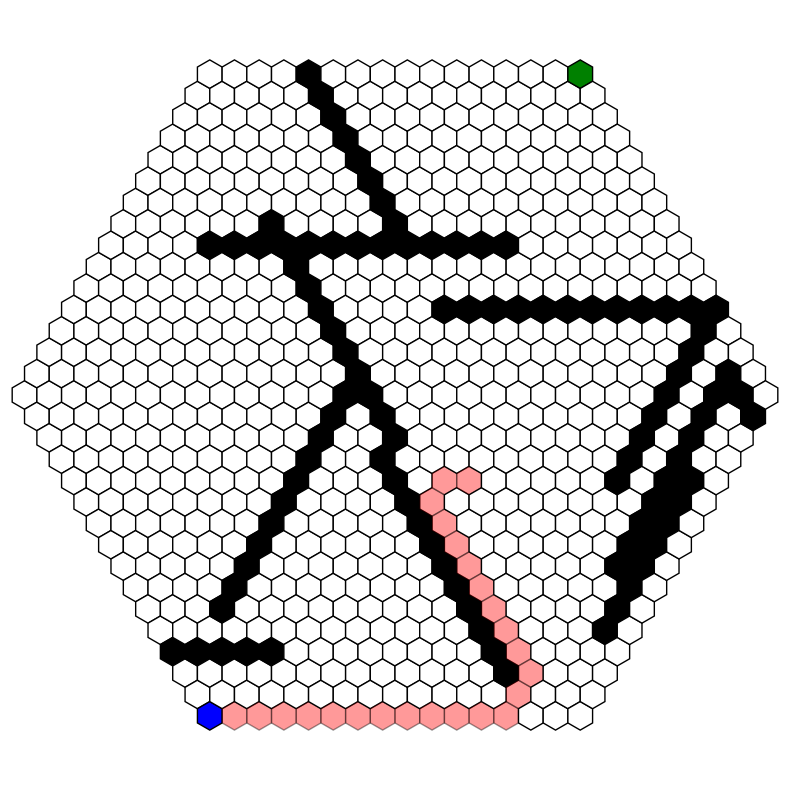

In [91]:
# Dictionaries to store the data
states_data = {}
nodes_data = {}
branching_data = {}
depths_data = {}
problems = {}
solutions = {}

# Heuristic functions to use
#heuristics = [zero_heuristic, box_goal_euclidian_distance, box_goal_manhattan_distance]

maps = [
    'r3h0.33.pkl',
    'r15h1.00.pkl',
]

for m in maps:
    print(f"Processing map file: {m}\n")
    states_expanded = []
    nodes_generated = []
    eff_branching_factors = []
    depths = []



    # Start the timer
    start = time.time()

    # Execute the search
    problem, solution = solve(maps_dir +"/"+ m)

    # Stop the timer
    end = time.time()

    # If a solution was found
    if solution is not None:
        consistent, states, nodes = problem.get_benchmarks()
        solution_cost = solution.path_cost
        states_expanded.append(states)
        nodes_generated.append(nodes)
        depths.append(solution_cost)

        current_node = solution
        solution_path = []
        while current_node.parent is not None:
            # print(current_node.state)
            # print(current_node.path_cost)
            loc, v = current_node.state
            cost = current_node.path_cost
            solution_path.append(loc)
            #velocities.append(v)
            #path_costs.append(cost)
            current_node = current_node.parent


        solution_path = list(reversed(solution_path))
        #velocities = list(reversed(velocities))
        #path_costs = list(reversed(path_costs))
        eff_branch_factor = pow(nodes, 1/len(solution_path))
        eff_branching_factors.append(eff_branch_factor)
        plot_problem(problem, solution_path)
    else:
        solution_cost = None
        eff_branch_factor = None
    print(f"Solution depth {len(solution_path)} found in {end-start} seconds\nExplored {nodes} states.")
    if not consistent:
        print(f"Test case {m} has shown the heuristic is not consistent")
    states_data[m] = states_expanded
    nodes_data[m] = nodes_generated
    branching_data[m] = eff_branching_factors
    depths_data[m] = depths
    problems[m] = problem
    solutions[m] = solution